## Med 2: acero inoxidable L=30 cm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, fftfreq
import pandas as pd 
from scipy.optimize import curve_fit
from scipy.stats import chi2
from uncertainties import ufloat

In [3]:
file_path = "C:/Users/FIUBA/Desktop/Labo 4/mod young/mediciones24-2/med2-24-2-acero-inoxidable-30cm0.csv"
df = pd.read_csv(file_path)

df.columns = ["t","V"]

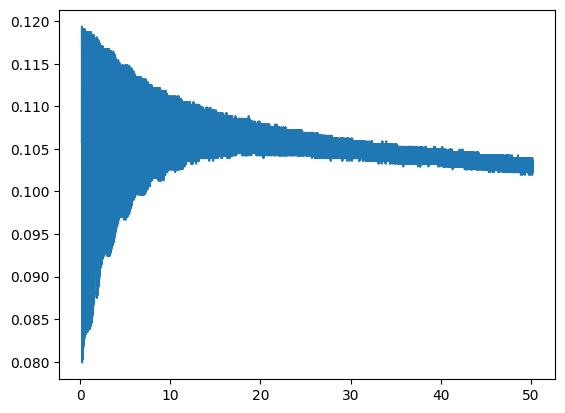

In [4]:
plt.plot(df["t"], df["V"])

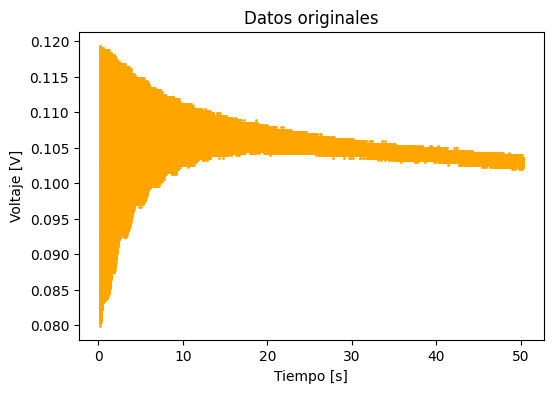

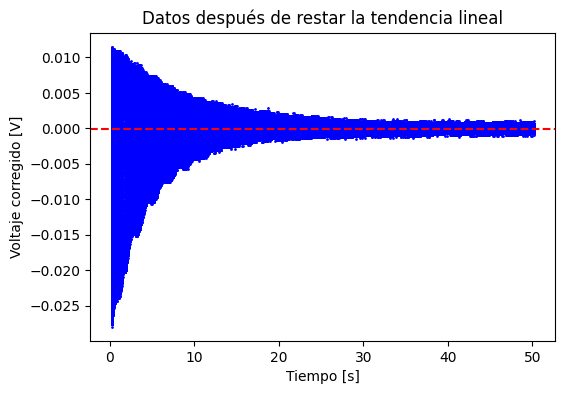

Ecuación de la recta ajustada: V(t) = -0.000099 * t + 0.107888
mean: -4.207138968980656e-05


In [5]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

fraction = 0.5
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

p = np.polyfit(df_tail["t"], df_tail["V"], 1)  

recta_ajustada = np.polyval(p, df["t"])

df["V1_corregido"] = df["V"] - recta_ajustada

plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V1_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V1_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V1_corregido'])}")

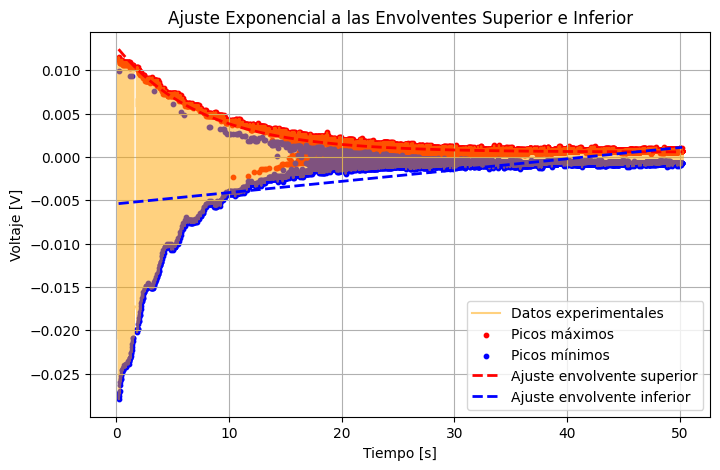

Coeficiente de amortiguamiento (envolvente superior): α_max = 0.13184 s⁻¹
Coeficiente de amortiguamiento (envolvente inferior): α_min = -0.00000 s⁻¹


In [7]:
#data_downsampled = data.iloc[::50]  # Tomar 1 de cada 50 puntos
from scipy.signal import argrelextrema

tiempo_np = df["t"].to_numpy()
voltaje_np = df["V1_corregido"].to_numpy()

# Encontrar los picos máximos y mínimos locales
ventana = 50  # Tamaño de la ventana para encontrar los extremos
indices_maximos = argrelextrema(voltaje_np, np.greater, order=ventana)[0]
indices_minimos = argrelextrema(voltaje_np, np.less, order=ventana)[0]

# Extraer los valores correspondientes a las envolventes
tiempo_max = tiempo_np[indices_maximos]
voltaje_max = voltaje_np[indices_maximos]
tiempo_min = tiempo_np[indices_minimos]
voltaje_min = voltaje_np[indices_minimos]

# Definir modelo exponencial para el ajuste
def modelo_amortiguado(t, A, alpha, C):
    return A * np.exp(-alpha * t) + C

# Estimaciones iniciales para el ajuste
A_inicial = voltaje_max.max() - voltaje_max.min()
alpha_inicial = 0.1  # Valor estimado para la atenuación
C_inicial = voltaje_min.min()

# Ajuste exponencial para la envolvente superior
popt_max, _ = curve_fit(modelo_amortiguado, tiempo_max, voltaje_max, 
                        p0=[A_inicial, alpha_inicial, C_inicial], maxfev=5000)

# Ajuste exponencial para la envolvente inferior
popt_min, _ = curve_fit(modelo_amortiguado, tiempo_min, voltaje_min, 
                        p0=[A_inicial, alpha_inicial, C_inicial], maxfev=5000)

# Parámetros obtenidos
alpha_max = popt_max[1]
alpha_min = popt_min[1]

# Generar valores ajustados para graficar
t_fit = np.linspace(df["t"].min(), df["t"].max(), 1000)
voltaje_fit_max = modelo_amortiguado(t_fit, *popt_max)
voltaje_fit_min = modelo_amortiguado(t_fit, *popt_min)

# Graficar los resultados
plt.figure(figsize=(8,5))
plt.plot(df["t"], df["V1_corregido"], 'orange', alpha=0.5, label="Datos experimentales")
plt.scatter(tiempo_max, voltaje_max, color='red', label="Picos máximos", s=10)
plt.scatter(tiempo_min, voltaje_min, color='blue', label="Picos mínimos", s=10)
plt.plot(t_fit, voltaje_fit_max, 'r--', linewidth=2, label="Ajuste envolvente superior")
plt.plot(t_fit, voltaje_fit_min, 'b--', linewidth=2, label="Ajuste envolvente inferior")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Ajuste Exponencial a las Envolventes Superior e Inferior")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar coeficientes de amortiguamiento
print(f"Coeficiente de amortiguamiento (envolvente superior): α_max = {alpha_max:.5f} s⁻¹")
print(f"Coeficiente de amortiguamiento (envolvente inferior): α_min = {alpha_min:.5f} s⁻¹")


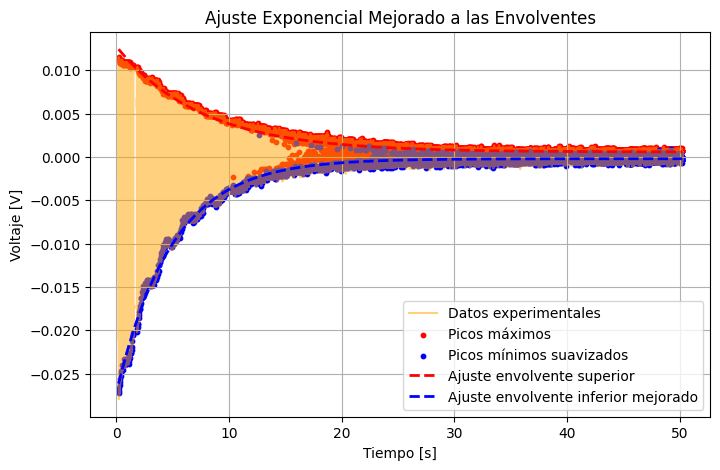

Coeficiente de amortiguamiento (envolvente superior): α_max = 0.13184 s⁻¹
Coeficiente de amortiguamiento mejorado (envolvente inferior): α_min = 0.20296 s⁻¹


In [ ]:
from scipy.ndimage import gaussian_filter1d

voltaje_suavizado = gaussian_filter1d(voltaje_np, sigma=5)

indices_minimos_suav = argrelextrema(voltaje_suavizado, np.less, order=ventana)[0]

tiempo_min_suav = tiempo_np[indices_minimos_suav]
voltaje_min_suav = voltaje_np[indices_minimos_suav]

popt_min_suav, _ = curve_fit(modelo_amortiguado, tiempo_min_suav, voltaje_min_suav, 
                             p0=[A_inicial, alpha_inicial, C_inicial], maxfev=5000)

voltaje_fit_min_suav = modelo_amortiguado(t_fit, *popt_min_suav)

plt.figure(figsize=(8,5))
plt.plot(df["t"], df["V1_corregido"], 'orange', alpha=0.5, label="Datos experimentales")
plt.scatter(tiempo_max, voltaje_max, color='red', label="Picos máximos", s=10)
plt.scatter(tiempo_min_suav, voltaje_min_suav, color='blue', label="Picos mínimos suavizados", s=10)
plt.plot(t_fit, voltaje_fit_max, 'r--', linewidth=2, label="Ajuste envolvente superior")
plt.plot(t_fit, voltaje_fit_min_suav, 'b--', linewidth=2, label="Ajuste envolvente inferior mejorado")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Ajuste Exponencial Mejorado a las Envolventes")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar coeficientes de amortiguamiento
alpha_min_suav = popt_min_suav[1]
print(f"Coeficiente de amortiguamiento (envolvente superior): α_max = {alpha_max:.5f} s⁻¹")
print(f"Coeficiente de amortiguamiento mejorado (envolvente inferior): α_min = {alpha_min_suav:.5f} s⁻¹")


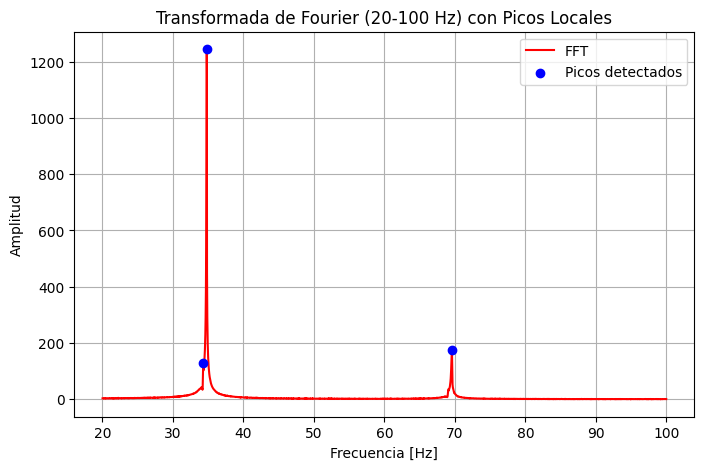

Frecuencias detectadas en el rango 20-100 Hz: [34.29683864 34.79679256 69.57358696]
Frecuencia dominante: 34.80 Hz


In [13]:
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

n_samples = len(tiempo_np)
frecuencia_muestreo = 1 / np.mean(np.diff(tiempo_np))

fft_result = fft(voltaje_np)
frecuencias = fftfreq(n_samples, d=1/frecuencia_muestreo)

mask = (frecuencias >= 20) & (frecuencias <= 100)
frecuencias_filtradas = frecuencias[mask]
fft_magnitud_filtrada = np.abs(fft_result[mask])

peaks, _ = find_peaks(fft_magnitud_filtrada, height=np.max(fft_magnitud_filtrada) * 0.1)

plt.figure(figsize=(8,5))
plt.plot(frecuencias_filtradas, fft_magnitud_filtrada, 'r', label="FFT")
plt.scatter(frecuencias_filtradas[peaks], fft_magnitud_filtrada[peaks], color='b', label="Picos detectados", zorder=3)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")
plt.title("Transformada de Fourier (20-100 Hz) con Picos Locales")
plt.legend()
plt.grid(True)
plt.show()

frecuencias_detectadas = frecuencias_filtradas[peaks]
print("Frecuencias detectadas en el rango 20-100 Hz:", frecuencias_detectadas)
print(f"Frecuencia dominante: {frecuencias_filtradas[np.argmax(fft_magnitud_filtrada)]:.2f} Hz")


In [31]:
len(fft_magnitud_filtrada)
N = len(voltaje_np)  # O el número de datos en la señal
print(N)


1242660


### Calculamos E


In [17]:
# Nuevo diámetro de la barra en metros
f1 = 34.80
d = 0.6e-2  # 0.6 cm = 0.006 m
rho = 7850
omega_n = 2 * np.pi * f1
n = 1  
L = 0.3

K1 = (n * np.pi) / L

# Recalcular el momento de inercia I para una barra cilíndrica
I = (np.pi / 64) * d**4  

# Recalcular la densidad lineal de la barra (kg/m)
rho_l = rho * (np.pi * (d/2)**2)  

# Recalcular el módulo de Young E
E = ((omega_n**2 + alpha_min**2) * rho_l) / (I * K1**4)
print(f"Módulo de Young: {E:.2e} Pa")


Módulo de Young: 1.39e+10 Pa


In [24]:
# NO asumimos que es completamente cobre
alfa = 0.20296
d = 0.6/100 # en metros
rho = (123/1000)*(1/(0.28))  #del cobre
I = (np.pi * (d)**4)/64
L = 0.28 #en metros
k = 1.875/L
frecuencia_dominante = 34.79679256

#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print(f"Módulo de Young: {E / 1e9:.2f} GPa")

Módulo de Young: 164.15 GPa


In [32]:
L_err = 0.005 
d_err = 1*10**(-5)
rho_err = 0.00033 # por impuresas me tiro chat
f_err = 25000/1242660 # frec de meustreo/numero de puntos de la fft (voltaje_np)
alpha_err = 0.0027 # sale de la matriz de covarianza

from uncertainties import ufloat

alfa_u = ufloat(alfa, alpha_err)
d_u = ufloat(d, d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + alfa_u**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 164.15+/-11.78 GPa
